## Loading libraries

In [1]:
# env: Maia
import numpy as np
import pandas as pd

## Simulating data

In [2]:
np.random.seed(42)

n_users = 2000

users = pd.DataFrame({
    "user_id": range(n_users),
    "is_new_user": np.random.binomial(1, 0.6, n_users),
    "sessions_last_7d": np.random.poisson(2, n_users),
    "days_since_last_event": np.random.exponential(3, n_users)
})

In [3]:
rows = []

for _, u in users.iterrows():
    for weekday in range(7):
        for hour in range(24):
            rows.append({
                "user_id": u["user_id"],
                "weekday": weekday,
                "hour": hour,
                "is_new_user": u["is_new_user"],
                "sessions_last_7d": u["sessions_last_7d"],
                "days_since_last_event": u["days_since_last_event"]
            })

df = pd.DataFrame(rows)
df.head()

,user_id,weekday,hour,is_new_user,sessions_last_7d,days_since_last_event
0,0.0,0,0,1.0,1.0,6.945771
1,0.0,0,1,1.0,1.0,6.945771
2,0.0,0,2,1.0,1.0,6.945771
3,0.0,0,3,1.0,1.0,6.945771
4,0.0,0,4,1.0,1.0,6.945771


In [4]:
df.shape

(336000, 6)

In [5]:
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)

### Simulating conversion behavior

In [7]:
base = -5.2

hour_effect = ((df["hour"] >= 16) & (df["hour"] <= 20)).astype(int) * 1.4
weekday_effect = (df["weekday"] == 4).astype(int) * 1.1  # Friday

engagement_effect = (
    df["sessions_last_7d"] * 0.3
    - df["days_since_last_event"] * 0.15
)

new_user_penalty = df["is_new_user"] * -0.4

logit = (
    base
    + hour_effect
    + weekday_effect
    + engagement_effect
    + new_user_penalty
)

prob = 1 / (1 + np.exp(-logit))
df["converted"] = np.random.binomial(1, prob)
df.head()

,user_id,weekday,hour,is_new_user,sessions_last_7d,days_since_last_event,is_weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,converted
0,0.0,0,0,1.0,1.0,6.945771,0,0.000000,1.000000,0.0,1.0,0
1,0.0,0,1,1.0,1.0,6.945771,0,0.258819,0.965926,0.0,1.0,0
2,0.0,0,2,1.0,1.0,6.945771,0,0.500000,0.866025,0.0,1.0,0
3,0.0,0,3,1.0,1.0,6.945771,0,0.707107,0.707107,0.0,1.0,0
4,0.0,0,4,1.0,1.0,6.945771,0,0.866025,0.500000,0.0,1.0,0


## Training model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [9]:
features = [
    "weekday", "hour",
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",
    "is_weekend",
    "is_new_user",
    "sessions_last_7d",
    "days_since_last_event"
]

X = df[features]
y = df["converted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=25,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

ROC AUC: 0.7333398964564983


## Predicting probability of conversion

In [11]:
example = pd.DataFrame([{
    "weekday": 4,   # Friday
    "hour": 17,
    "hour_sin": np.sin(2*np.pi*17/24),
    "hour_cos": np.cos(2*np.pi*17/24),
    "weekday_sin": np.sin(2*np.pi*4/7),
    "weekday_cos": np.cos(2*np.pi*4/7),
    "is_weekend": 0,
    "is_new_user": 0,
    "sessions_last_7d": 4,
    "days_since_last_event": 1.0
}])

display(example)

prob = model.predict_proba(example)[0, 1]
print(f"Conversion probability: {prob:.2%}")

,weekday,hour,hour_sin,hour_cos,weekday_sin,weekday_cos,is_weekend,is_new_user,sessions_last_7d,days_since_last_event
0,4,17,-0.965926,-0.258819,-0.433884,-0.900969,0,0,4,1.0


Conversion probability: 93.67%


## Generating probabilities for all weekday x hour combinations (Scenario 1)

In [12]:
grid = pd.DataFrame([
    {"weekday": d, "hour": h}
    for d in range(7)
    for h in range(24)
])

grid["is_weekend"] = grid["weekday"].isin([5,6]).astype(int)
grid["hour_sin"] = np.sin(2*np.pi*grid["hour"]/24)
grid["hour_cos"] = np.cos(2*np.pi*grid["hour"]/24)
grid["weekday_sin"] = np.sin(2*np.pi*grid["weekday"]/7)
grid["weekday_cos"] = np.cos(2*np.pi*grid["weekday"]/7)

# fixed user state (scenario)
grid["is_new_user"] = 0
grid["sessions_last_7d"] = 4
grid["days_since_last_event"] = 1.0

grid["conversion_prob"] = model.predict_proba(grid[features])[:, 1]

In [13]:
grid

,weekday,hour,is_weekend,hour_sin,hour_cos,weekday_sin,weekday_cos,is_new_user,sessions_last_7d,days_since_last_event,conversion_prob
0,0,0,0,0.000000,1.000000,0.000000,1.00000,0,4,1.0,0.393262
1,0,1,0,0.258819,0.965926,0.000000,1.00000,0,4,1.0,0.486164
2,0,2,0,0.500000,0.866025,0.000000,1.00000,0,4,1.0,0.551601
3,0,3,0,0.707107,0.707107,0.000000,1.00000,0,4,1.0,0.545415
4,0,4,0,0.866025,0.500000,0.000000,1.00000,0,4,1.0,0.584001
...,...,...,...,...,...,...,...,...,...,...,...
163,6,19,1,-0.965926,0.258819,-0.781831,0.62349,0,4,1.0,0.783835
164,6,20,1,-0.866025,0.500000,-0.781831,0.62349,0,4,1.0,0.736791
165,6,21,1,-0.707107,0.707107,-0.781831,0.62349,0,4,1.0,0.409650
166,6,22,1,-0.500000,0.866025,-0.781831,0.62349,0,4,1.0,0.418697


In [14]:
heatmap_df = grid.pivot(
    index="weekday",
    columns="hour",
    values="conversion_prob"
)
heatmap_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,0.393262,0.486164,0.551601,0.545415,0.584001,0.521174,0.576620,0.524197,0.496526,0.524267,...,0.479646,0.494260,0.702571,0.740652,0.797456,0.814720,0.755760,0.354720,0.344278,0.377559
1,0.378940,0.502997,0.488020,0.489037,0.498683,0.524473,0.527491,0.501957,0.450873,0.438207,...,0.448880,0.470670,0.790628,0.766333,0.800353,0.803682,0.786215,0.455987,0.427044,0.452299
2,0.489001,0.508778,0.476524,0.536220,0.503486,0.425502,0.402100,0.489667,0.522783,0.521532,...,0.598680,0.596092,0.860846,0.825194,0.850813,0.825983,0.776640,0.472124,0.438242,0.406855
3,0.363070,0.359635,0.378263,0.334968,0.274408,0.258607,0.230485,0.246200,0.299647,0.305528,...,0.395506,0.423460,0.773435,0.696021,0.798743,0.714229,0.677262,0.549800,0.434794,0.431088
4,0.486136,0.685271,0.719992,0.689682,0.676835,0.650897,0.680946,0.698852,0.677232,0.699160,...,0.793472,0.749034,0.922196,0.936728,0.922693,0.932188,0.870519,0.709595,0.621618,0.557743
5,0.509102,0.567104,0.555593,0.532691,0.588603,0.416280,0.573503,0.472836,0.537438,0.545040,...,0.583741,0.612483,0.830786,0.839633,0.795493,0.827287,0.792881,0.508009,0.542514,0.548660
6,0.370770,0.546960,0.469533,0.572508,0.707490,0.443902,0.590955,0.511095,0.597092,0.450005,...,0.445963,0.446929,0.801018,0.798556,0.781479,0.783835,0.736791,0.409650,0.418697,0.548976


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

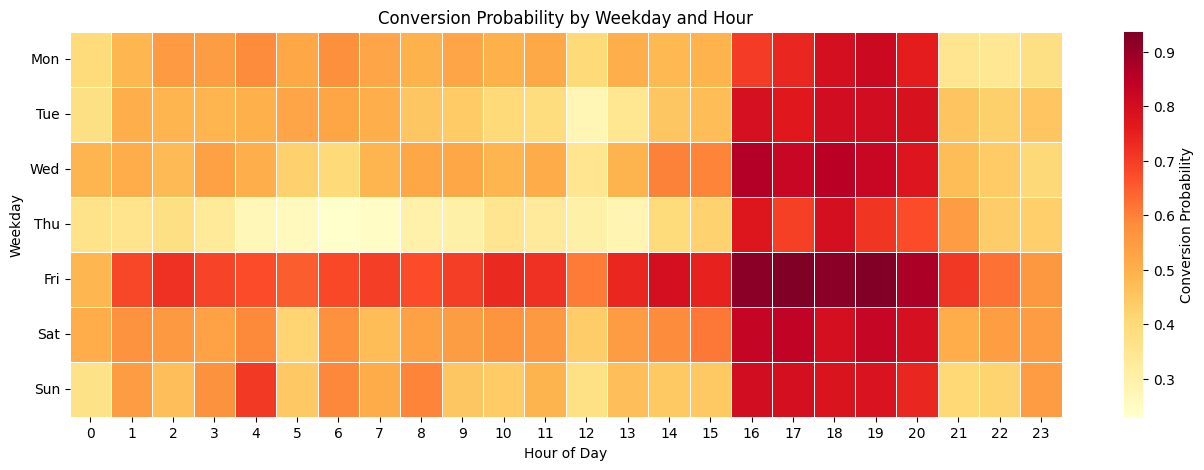

In [16]:
plt.figure(figsize=(16, 5))

sns.heatmap(
    heatmap_df,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={"label": "Conversion Probability"}
)

plt.title("Conversion Probability by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")

plt.yticks(
    ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5],
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0
)

plt.show()

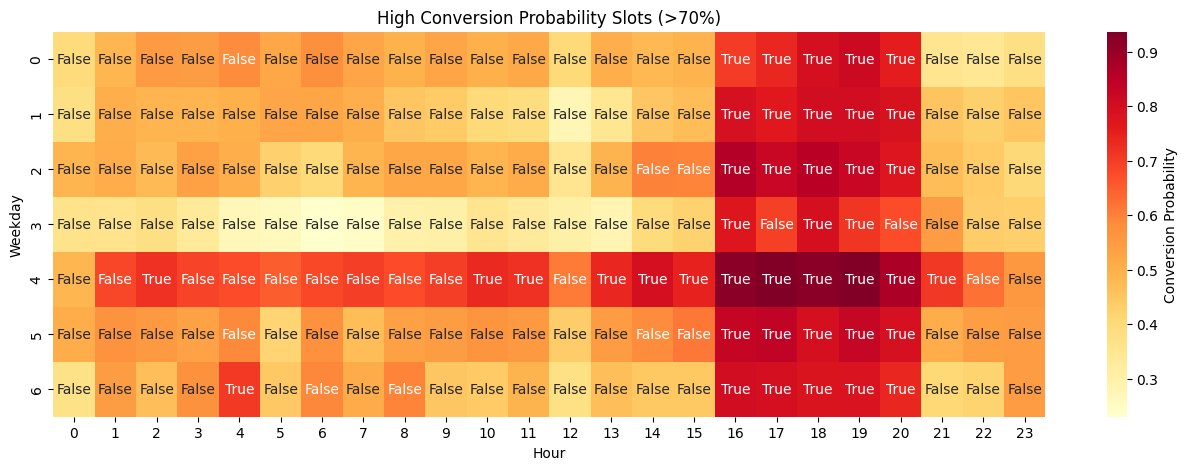

In [17]:
plt.figure(figsize=(16, 5))

sns.heatmap(
    heatmap_df,
    cmap="YlOrRd",
    annot=heatmap_df > 0.7,
    fmt="",
    cbar_kws={"label": "Conversion Probability"}
)

plt.title("High Conversion Probability Slots (>70%)")
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.show()

## Normalization per weekday

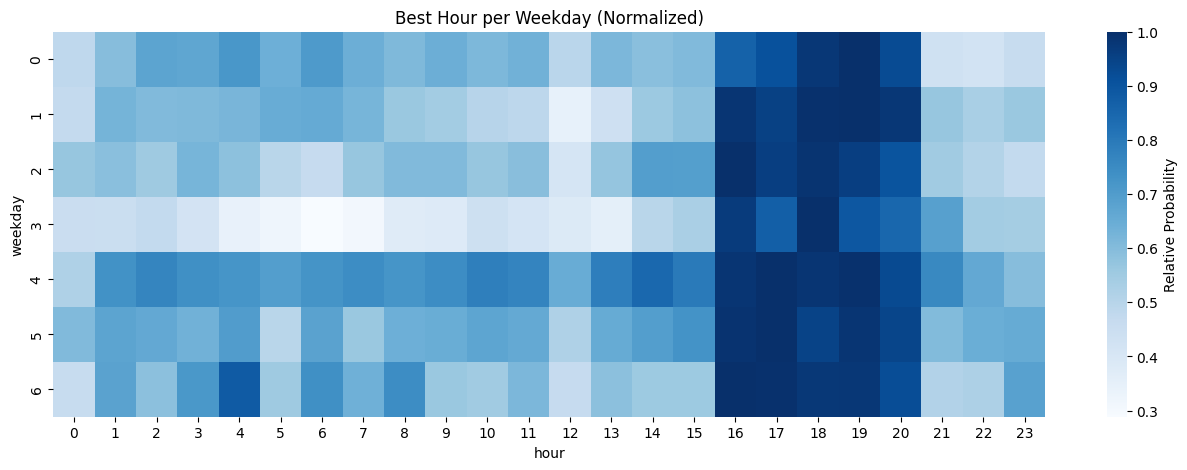

In [19]:
heatmap_norm = heatmap_df.div(heatmap_df.max(axis=1), axis=0)

plt.figure(figsize=(16, 5))

sns.heatmap(
    heatmap_norm,
    cmap="Blues",
    cbar_kws={"label": "Relative Probability"}
)
plt.title("Best Hour per Weekday (Normalized)")
plt.show()